In [21]:
import torch
import time
import numpy as np
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
DAE_np_data_path = r'data\np\npData.csv'

np_DAE_df = pd.read_csv(DAE_np_data_path)

In [3]:
# A dataset of 
np_DAE_df = np_DAE_df[np_DAE_df['author1'] != 'K.H.Hicks+'] # Dataset has multiple authors, we keep only B.K.Park+ to ensure only one target material...

In [4]:
np_DAE_df

,DatasetID,year1,author1,y:Value,y,dy,x1:ResEn,x1(eV),dx1(eV),x2:IncEn,...,Proj,Emiss,Prod1,MF,MT,ReacType,Quant1,nx,indVars,Reacode
205,13530002,1993,B.K.Park+,Data(B/SR/EV),2.332000e-07,6.086000e-08,NaN,NaN,NaN,EN(EV),...,N,P,15-P-32,6,103,DAE,DAE,3,234,"16-S-32(N,P)15-P-32,,DA/DE"
206,13530002,1993,B.K.Park+,Data(B/SR/EV),1.133000e-07,4.229000e-08,NaN,NaN,NaN,EN(EV),...,N,P,15-P-32,6,103,DAE,DAE,3,234,"16-S-32(N,P)15-P-32,,DA/DE"
207,13530002,1993,B.K.Park+,Data(B/SR/EV),8.373000e-08,3.650000e-08,NaN,NaN,NaN,EN(EV),...,N,P,15-P-32,6,103,DAE,DAE,3,234,"16-S-32(N,P)15-P-32,,DA/DE"
208,13530002,1993,B.K.Park+,Data(B/SR/EV),0.000000e+00,0.000000e+00,NaN,NaN,NaN,EN(EV),...,N,P,15-P-32,6,103,DAE,DAE,3,234,"16-S-32(N,P)15-P-32,,DA/DE"
209,13530002,1993,B.K.Park+,Data(B/SR/EV),3.774000e-07,7.774000e-08,NaN,NaN,NaN,EN(EV),...,N,P,15-P-32,6,103,DAE,DAE,3,234,"16-S-32(N,P)15-P-32,,DA/DE"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13552,13530013,1993,B.K.Park+,Data(B/SR/EV),6.241000e-07,1.777000e-07,NaN,NaN,NaN,EN(EV),...,N,P,15-P-32,6,103,DAE,DAE,3,234,"16-S-32(N,P)15-P-32,,DA/DE"
13553,13530013,1993,B.K.Park+,Data(B/SR/EV),7.420000e-07,1.948000e-07,NaN,NaN,NaN,EN(EV),...,N,P,15-P-32,6,103,DAE,DAE,3,234,"16-S-32(N,P)15-P-32,,DA/DE"
13554,13530013,1993,B.K.Park+,Data(B/SR/EV),6.237000e-07,1.786000e-07,NaN,NaN,NaN,EN(EV),...,N,P,15-P-32,6,103,DAE,DAE,3,234,"16-S-32(N,P)15-P-32,,DA/DE"
13555,13530013,1993,B.K.Park+,Data(B/SR/EV),1.247000e-06,2.536000e-07,NaN,NaN,NaN,EN(EV),...,N,P,15-P-32,6,103,DAE,DAE,3,234,"16-S-32(N,P)15-P-32,,DA/DE"


In [9]:
np_DAE_df = np_DAE_df[np_DAE_df['x2(eV)'] != 2.98e8]

In [5]:
np_DAE_df['x2(eV)'].unique()

array([6.5e+07, 7.5e+07, 8.5e+07, 9.5e+07, 1.1e+08, 1.3e+08, 1.5e+08,
       1.7e+08, 1.9e+08, 2.1e+08, 2.3e+08, 2.5e+08])

In [10]:
df = np_DAE_df[['x2(eV)', 'x3(eV)', 'x4(deg)','y', 'dy']]

df = df.rename(columns={
    'x2(eV)': 'E_inc',
    'x3(eV)': 'E_sec',
    'x4(deg)': 'theta',
    'y': 'ddcs',  # double differential cross section
    'dy': 'Errddcs'  # Error on double differential cross section --> Could use this to weigh the KL loss (IDEA)

})

# df['E_inc'] = df['E_inc'] / 1e6  # eV → MeV
# df['E_sec'] = df['E_sec'] / 1e6  # eV → MeV

# Drop rows with missing values
df = df.dropna(subset=['E_inc', 'E_sec', 'theta', 'ddcs'])

df['E_inc'].unique()

array([6.5e+07, 7.5e+07, 8.5e+07, 9.5e+07, 1.1e+08, 1.3e+08, 1.5e+08,
       1.7e+08, 1.9e+08, 2.1e+08, 2.3e+08, 2.5e+08])

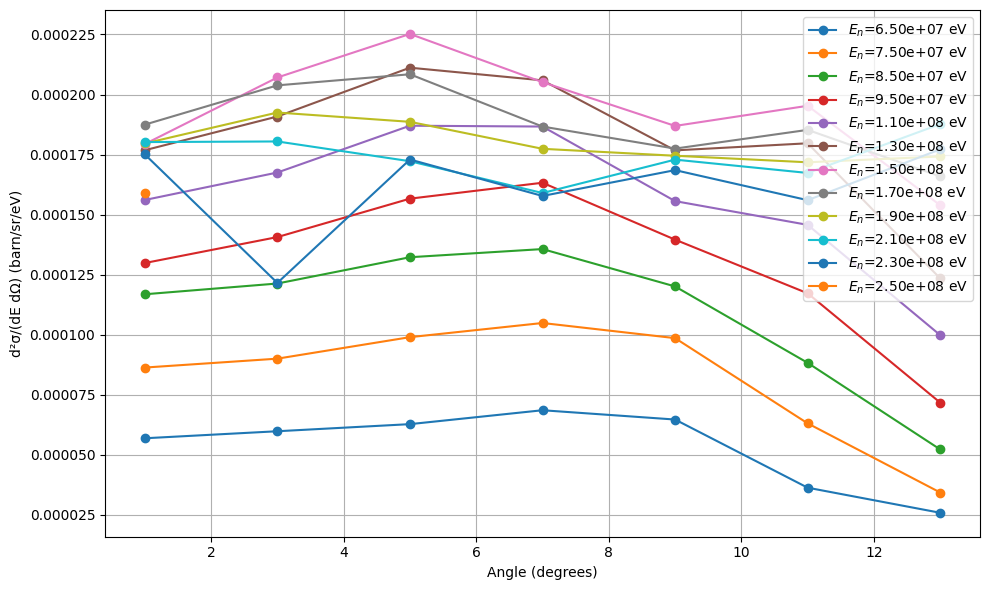

In [11]:
angle_max = np.max(df['theta'].unique())
unique_angles = np.sort(df['theta'].unique())

# energies_to_plot = np.linspace(df['E_inc'].min(), df['E_inc'].max(), 10)  # 10 evenly spaced energies
energies_to_plot = df['E_inc'].unique()
tolerance = 0.05  # MeV

plt.figure(figsize=(10, 6))

for E_n in energies_to_plot:
    # if E_n == 2.98e8:
    #     continue
    
    df_slice = df[np.abs(df['E_inc'] - E_n) < tolerance] 
    if df_slice.empty:
        continue
    
    grouped = df_slice.groupby('theta')['ddcs'].sum()
    angles_present = grouped.index.to_numpy()
    y_vals = grouped.to_numpy()

    plt.plot(angles_present, y_vals, marker='o', label=rf"$E_n$={E_n:.2e} eV")

plt.xlabel("Angle (degrees)")
plt.ylabel("d²σ/(dE dΩ) (barn/sr/eV)")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
# plt.yscale('log')  # optional log scale for better visibility
plt.show()


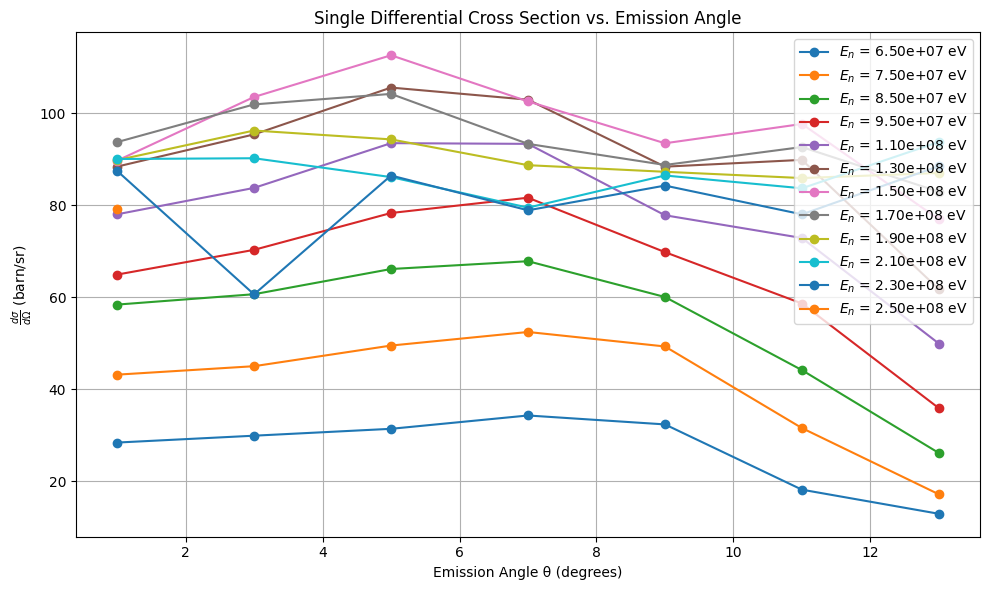

In [ ]:
# Get sorted unique incident energies and angles
energies_to_plot = np.sort(df['E_inc'].unique())
unique_angles = np.sort(df['theta'].unique())
tolerance = 0.05  # MeV

plt.figure(figsize=(10, 6))

for E_n in energies_to_plot:
    # if E_n == 2.98e8:  # skipping unwanted energies
    #     continue

    # Select data near the current incident energy
    df_slice = df[np.abs(df['E_inc'] - E_n) < tolerance]
    if df_slice.empty:
        continue

    # Group by angle and integrate DDCS over E_sec
    dsigma_dOmega_vals = []
    angles_present = []

    for angle, group in df_slice.groupby('theta'):
        # Sort by emitted proton energy
        group_sorted = group.sort_values('E_sec')
        # Perform numerical integration over E_sec
        integral = np.trapezoid(group_sorted['ddcs'], group_sorted['E_sec'])
        dsigma_dOmega_vals.append(integral)
        angles_present.append(angle)

    # Plot dsigma/dOmega vs angle
    plt.plot(angles_present, dsigma_dOmega_vals, marker='o', label=rf"$E_n$ = {E_n:.2e} eV")

plt.xlabel("Emission Angle θ (degrees)")
plt.ylabel(r"$\frac{d\sigma}{d\Omega}$ (barn/sr)")
plt.title("Single Differential Cross Section vs. Emission Angle")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
# plt.yscale('log')  # optional
plt.show()

In [13]:
def simulate_ddcs(random_tensor, E_n_lab, N_theta_bins=13, N_E_bins=100, device = 'cpu'):
    """
    Simulates DDCS for the reaction 32S(n,p)32P.
    
    Parameters:
        random_tensor (torch.Tensor): 1D tensor of uniform random numbers in [0, 1], length N_samples
        E_n_lab (float): Incident neutron energy in MeV (lab frame)
        N_theta_bins (int): Number of angular bins (0-180 deg)
        N_E_bins (int): Number of energy bins for emitted proton
    
    Returns:
        ddcs (torch.Tensor): 2D histogram [theta_bin, energy_bin]
        theta_edges (torch.Tensor), E_edges (torch.Tensor): Bin edges
    """
    # assert random_tensor.ndim == 1, "Input must be 1D tensor"
    device = torch.device(device)
    dtype = random_tensor.dtype
    N_samples = len(random_tensor)

    # Atomic masses (u), converted to MeV
    u_to_MeV = torch.tensor(931.494, device=device, dtype=dtype)
    m_n = torch.tensor(1.008664, device=device, dtype=dtype) * u_to_MeV
    m_p = torch.tensor(1.007276, device=device, dtype=dtype) * u_to_MeV
    m_S = torch.tensor(31.972071, device=device, dtype=dtype) * u_to_MeV
    m_P = torch.tensor(31.973907, device=device, dtype=dtype) * u_to_MeV

    Q = (m_S + m_n - m_P - m_p)  # Q-value in MeV

    # Sample angles isotropically in CM frame
    cos_theta_cm = 2 * random_tensor - 1
    theta_cm_rad = torch.acos(cos_theta_cm)  # in radians
    theta_deg = torch.rad2deg(theta_cm_rad)

    # Reduced mass of initial system
    M_tot = m_n + m_S
    mu_in = (m_n * m_S) / M_tot

    # CM energy
    E_cm = mu_in * E_n_lab / m_n

    # Available energy in CM
    E_available = E_cm + Q

    # Reduced mass of final system
    mu_out = (m_p * m_P) / (m_p + m_P)

    # CM momentum of outgoing proton
    p_cm = torch.sqrt(2 * mu_out * E_available)

    # Velocity of CM
    v_cm = m_n * torch.sqrt(2 * E_n_lab / m_n) / M_tot

    # Proton velocity in CM frame
    v_p_cm = p_cm / m_p

    # Compute lab-frame proton energy
    E_p_lab = 0.5 * m_p * (v_p_cm**2 + v_cm**2 + 2 * v_p_cm * v_cm * cos_theta_cm)
    E_p_lab = E_p_lab / u_to_MeV  # Convert to MeV

    # Bin the results into (theta, E_p) histogram
    theta_bins = torch.linspace(0, N_theta_bins, N_theta_bins + 1, device=device, dtype=dtype)
    E_bins = torch.linspace(0, torch.max(E_p_lab)*1.05, N_E_bins + 1, device=device, dtype=dtype)

    # Create 2D histogram using PyTorch
    theta_indices = torch.bucketize(theta_deg, theta_bins) - 1
    E_indices = torch.bucketize(E_p_lab, E_bins) - 1
    
    # Filter out out-of-bounds values
    mask = (theta_indices >= 0) & (theta_indices < N_theta_bins) & \
           (E_indices >= 0) & (E_indices < N_E_bins)
    theta_indices = theta_indices[mask]
    E_indices = E_indices[mask]
    
    # Create 2D histogram
    ddcs = torch.zeros((N_theta_bins, N_E_bins), device=device, dtype=dtype)
    ddcs.index_put_((theta_indices, E_indices), torch.ones_like(theta_indices, dtype=dtype), accumulate=True)

    # Normalize to probability density
    ddcs = ddcs / ddcs.sum()

    return ddcs, theta_bins, E_bins


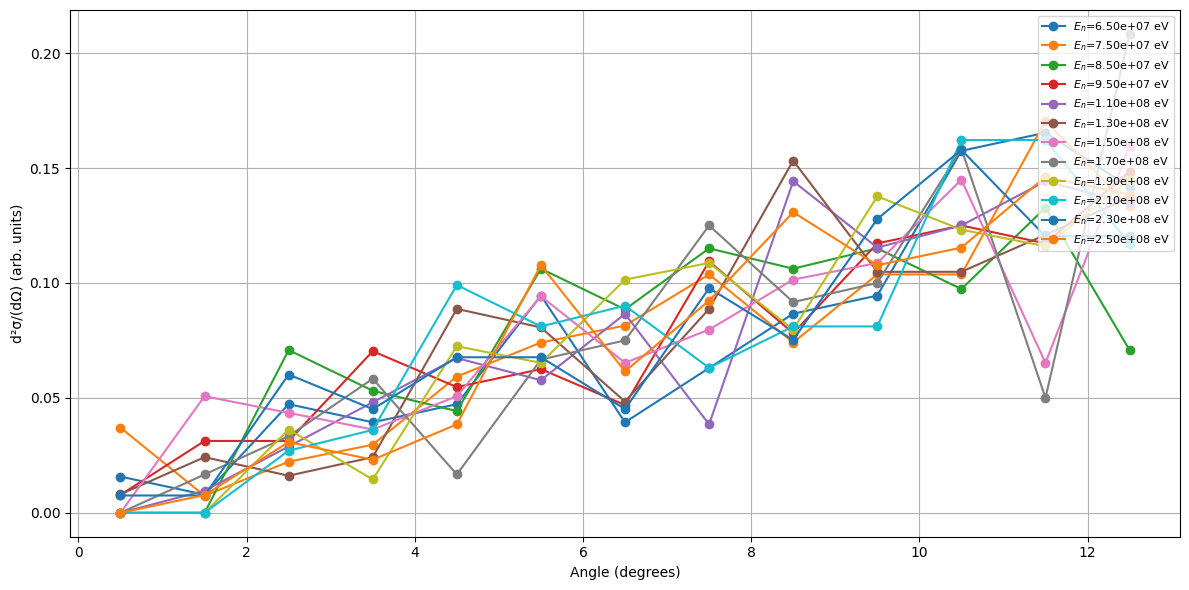

In [15]:
# Simulation neutron energies to match your experiment
energies_to_plot = [6.5e7, 7.5e7, 8.5e7, 9.5e7, 1.1e8, 1.3e8, 1.5e8, 1.7e8, 1.9e8, 2.1e8, 2.3e8, 2.5e8]  # eV
energies_to_plot = [E / 1e6 for E in energies_to_plot]  # convert to MeV

plt.figure(figsize=(12, 6))

for E_n in energies_to_plot:
    # Generate a batch of random samples for simulation
    rand_samples = torch.rand(1_000_0)
    
    # Run simulation for given E_n
    ddcs, theta_edges, E_edges = simulate_ddcs(rand_samples, N_theta_bins=13, E_n_lab=E_n)
    
    # Sum over energy to mimic experimental grouping: DDCS vs angle
    theta_centers = 0.5 * (theta_edges[:-1] + theta_edges[1:])
    ddcs_vs_angle = ddcs.sum(axis=1)  # sum over energy axis

    # Plot
    plt.plot(theta_centers, ddcs_vs_angle, marker='o', label=rf"$E_n$={E_n*1e6:.2e} eV")

plt.xlabel("Angle (degrees)")
plt.ylabel(r"d²σ/(dΩ) (arb. units)")
plt.legend(loc='upper right', fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Function
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def simulate_ddcs(random_tensor, E_n_lab, N_theta_bins=8, N_E_bins=13, device='cpu'):
    """
    Simulates DDCS for the reaction 32S(n,p)32P.
    
    Parameters:
        random_tensor (torch.Tensor): 1D tensor of uniform random numbers in [0, 1], length N_samples
        E_n_lab (float): Incident neutron energy in MeV (lab frame)
        N_theta_bins (int): Number of angular bins (0-180 deg)
        N_E_bins (int): Number of energy bins for emitted proton
    
    Returns:
        ddcs (torch.Tensor): 2D histogram [theta_bin, energy_bin]
        theta_edges (torch.Tensor), E_edges (torch.Tensor): Bin edges
    """
    device = torch.device(device)
    dtype = random_tensor.dtype
    N_samples = len(random_tensor)

    # Atomic masses (u), converted to MeV
    u_to_MeV = torch.tensor(931.494, device=device, dtype=dtype)
    m_n = torch.tensor(1.008664, device=device, dtype=dtype) * u_to_MeV
    m_p = torch.tensor(1.007276, device=device, dtype=dtype) * u_to_MeV
    m_S = torch.tensor(31.972071, device=device, dtype=dtype) * u_to_MeV
    m_P = torch.tensor(31.973907, device=device, dtype=dtype) * u_to_MeV

    Q = (m_S + m_n - m_P - m_p)  # Q-value in MeV

    # Sample angles isotropically in CM frame
    cos_theta_cm = 2 * random_tensor - 1
    theta_cm_rad = torch.acos(cos_theta_cm)  # in radians
    theta_deg = torch.rad2deg(theta_cm_rad)

    # Reduced mass of initial system
    M_tot = m_n + m_S
    mu_in = (m_n * m_S) / M_tot

    # CM energy
    E_cm = mu_in * E_n_lab / m_n

    # Available energy in CM
    E_available = E_cm + Q

    # Reduced mass of final system
    mu_out = (m_p * m_P) / (m_p + m_P)

    # CM momentum of outgoing proton
    p_cm = torch.sqrt(2 * mu_out * E_available)

    # Velocity of CM
    v_cm = m_n * torch.sqrt(2 * E_n_lab / m_n) / M_tot

    # Proton velocity in CM frame
    v_p_cm = p_cm / m_p

    # Compute lab-frame proton energy
    E_p_lab = 0.5 * m_p * (v_p_cm**2 + v_cm**2 + 2 * v_p_cm * v_cm * cos_theta_cm)
    E_p_lab = E_p_lab / u_to_MeV  # Convert to MeV

    # Bin the results into (theta, E_p) histogram
    theta_bins = torch.linspace(0, N_theta_bins, N_theta_bins + 1, device=device, dtype=dtype)
    E_bins = torch.linspace(0, torch.max(E_p_lab)*1.05, N_E_bins + 1, device=device, dtype=dtype)

    # Create 2D histogram using PyTorch
    theta_indices = torch.bucketize(theta_deg, theta_bins) - 1
    E_indices = torch.bucketize(E_p_lab, E_bins) - 1
    
    # Filter out out-of-bounds values
    mask = (theta_indices >= 0) & (theta_indices < N_theta_bins) & \
           (E_indices >= 0) & (E_indices < N_E_bins)
    theta_indices = theta_indices[mask]
    E_indices = E_indices[mask]
    
    # Create 2D histogram
    ddcs = torch.zeros((N_theta_bins, N_E_bins), device=device, dtype=dtype)
    ddcs.index_put_((theta_indices, E_indices), torch.ones_like(theta_indices, dtype=dtype), accumulate=True)

    # Normalize to probability density
    ddcs = ddcs / ddcs.sum()

    return ddcs, theta_bins, E_bins


class SimulationFunction(Function):
    @staticmethod
    def forward(ctx, uniform_samples, E_n, N_theta_bins=13, N_E_bins=100):
        """
        Forward pass of the simulation function.
        
        Args:
            ctx: Context object to save information for backward pass
            uniform_samples: Tensor of uniform random samples [0,1]
            E_n: Incident neutron energy (MeV)
            N_theta_bins: Number of theta bins
            N_E_bins: Number of energy bins
        """
        # Save inputs for backward pass
        ctx.save_for_backward(uniform_samples)
        ctx.E_n = E_n
        ctx.N_theta_bins = N_theta_bins
        ctx.N_E_bins = N_E_bins
        
        # Run simulation
        ddcs, theta_bins, E_bins = simulate_ddcs(
            uniform_samples,
            E_n_lab=E_n,
            N_theta_bins=N_theta_bins,
            N_E_bins=N_E_bins,
            device=uniform_samples.device
        )
        
        return ddcs

    @staticmethod
    def backward(ctx, grad_output):
        """
        Backward pass using finite differences approximation.
        
        Since the simulation involves discrete binning operations and random sampling,
        we approximate gradients using finite differences.
        """
        uniform_samples, = ctx.saved_tensors
        E_n = ctx.E_n
        N_theta_bins = ctx.N_theta_bins
        N_E_bins = ctx.N_E_bins
        
        # Initialize gradients
        grad_uniform_samples = None
        grad_E_n = None
        
        # Gradient w.r.t. uniform_samples
        if uniform_samples.requires_grad:
            # For uniform samples, gradient is typically zero or undefined
            # since changing uniform samples changes the random sampling
            # In practice, we often return zeros for stochastic operations
            grad_uniform_samples = torch.zeros_like(uniform_samples)
        
        # Gradient w.r.t. E_n using finite differences
        if ctx.needs_input_grad[1]:  # E_n requires grad
            eps = 1e-6
            
            # Forward pass with E_n + eps
            ddcs_plus, _, _ = simulate_ddcs(
                uniform_samples,
                E_n_lab=E_n + eps,
                N_theta_bins=N_theta_bins,
                N_E_bins=N_E_bins,
                device=uniform_samples.device
            )
            
            # Forward pass with E_n - eps
            ddcs_minus, _, _ = simulate_ddcs(
                uniform_samples,
                E_n_lab=E_n - eps,
                N_theta_bins=N_theta_bins,
                N_E_bins=N_E_bins,
                device=uniform_samples.device
            )
            
            # Finite difference approximation
            ddcs_grad = (ddcs_plus - ddcs_minus) / (2 * eps)
            
            # Chain rule: grad_E_n = sum(grad_output * ddcs_grad)
            grad_E_n = torch.sum(grad_output * ddcs_grad)
        
        return grad_uniform_samples, grad_E_n, None, None


class DDCSSimulationLayer(nn.Module):
    """
    PyTorch module wrapper for DDCS simulation.
    
    This layer performs Monte Carlo simulation of double differential cross sections
    for the 32S(n,p)32P nuclear reaction.
    """
    
    def __init__(self, E_n, N_theta_bins=13, N_E_bins=100):
        """
        Initialize the simulation layer.
        
        Args:
            E_n (float): Incident neutron energy in MeV
            N_theta_bins (int): Number of angular bins
            N_E_bins (int): Number of energy bins
        """
        super(DDCSSimulationLayer, self).__init__()
        self.register_buffer('E_n', torch.tensor(E_n, dtype=torch.float32))
        self.N_theta_bins = N_theta_bins
        self.N_E_bins = N_E_bins
    
    def forward(self, uniform_samples):
        """
        Forward pass through the simulation.
        
        Args:
            uniform_samples (torch.Tensor): 1D tensor of uniform random numbers [0,1]
            
        Returns:
            torch.Tensor: 2D histogram of DDCS [N_theta_bins, N_E_bins]
        """
        return SimulationFunction.apply(
            uniform_samples, 
            self.E_n, 
            self.N_theta_bins, 
            self.N_E_bins
        )
    
    def set_energy(self, E_n):
        """Update the incident neutron energy."""
        self.E_n.data = torch.tensor(E_n, dtype=self.E_n.dtype, device=self.E_n.device)

def prepare_experimental_data(df):
    """
    Prepare experimental data from pandas DataFrame.
    
    Args:
        df: pandas DataFrame with columns ['E_inc', 'E_sec', 'theta', 'ddcs', 'Errddcs']
    
    Returns:
        E_inc_values: tensor of unique incident energies in MeV
        experimental_ddcs: tensor of shape (n_energies, n_theta_bins)
        experimental_errors: tensor of shape (n_energies, n_theta_bins)
        valid_mask: tensor of shape (n_energies, n_theta_bins) - True where data exists
    """
    # Get unique incident energies and convert from eV to MeV
    theta_values = df['theta'].unique()
    E_inc_unique_eV = np.sort(df['E_inc'].unique())
    E_inc_unique = E_inc_unique_eV * 1e-6  # Convert eV to MeV
    n_energies = len(E_inc_unique)
    n_theta = len(theta_values)
    
    print(f"Experimental energies (eV): {E_inc_unique_eV}")
    print(f"Experimental energies (MeV): {E_inc_unique}")
    
    # Initialize arrays
    experimental_ddcs = np.full((n_energies, n_theta), np.nan)  # Use NaN instead of 0
    experimental_errors = np.full((n_energies, n_theta), np.nan)
    valid_mask = np.zeros((n_energies, n_theta), dtype=bool)
    
    # Fill the arrays
    for i, E_inc_eV in enumerate(E_inc_unique_eV):
        energy_data = df[df['E_inc'] == E_inc_eV]
        
        for j, theta in enumerate(theta_values):
            theta_data = energy_data[energy_data['theta'] == theta]
            
            if not theta_data.empty:
                # If multiple entries for same E_inc, theta, take the mean
                experimental_ddcs[i, j] = theta_data['ddcs'].mean()
                experimental_errors[i, j] = theta_data['Errddcs'].mean()
                valid_mask[i, j] = True
    
    # Handle missing data by interpolation across theta for each energy
    for i in range(n_energies):
        valid_indices = valid_mask[i, :]
        if np.sum(valid_indices) > 1:  # Need at least 2 points to interpolate
            valid_theta = theta_values[valid_indices]
            valid_ddcs = experimental_ddcs[i, valid_indices]
            valid_errors = experimental_errors[i, valid_indices]
            
            # Interpolate missing values
            if np.sum(~valid_indices) > 0:  # There are missing values
                from scipy.interpolate import interp1d
                
                # Linear interpolation for DDCS
                f_ddcs = interp1d(valid_theta, valid_ddcs, kind='linear', 
                                bounds_error=False, fill_value='extrapolate')
                experimental_ddcs[i, ~valid_indices] = f_ddcs(theta_values[~valid_indices])
                
                # Linear interpolation for errors
                f_errors = interp1d(valid_theta, valid_errors, kind='linear',
                                  bounds_error=False, fill_value='extrapolate')
                experimental_errors[i, ~valid_indices] = f_errors(theta_values[~valid_indices])
                
                # Update valid mask
                valid_mask[i, :] = True
    
    # Remove energies that have no valid data at all
    energies_with_data = np.any(valid_mask, axis=1)
    E_inc_unique = E_inc_unique[energies_with_data]
    experimental_ddcs = experimental_ddcs[energies_with_data]
    experimental_errors = experimental_errors[energies_with_data]
    valid_mask = valid_mask[energies_with_data]
    
    # Ensure no NaN values remain
    experimental_ddcs = np.nan_to_num(experimental_ddcs, nan=1e-10, posinf=1e10, neginf=1e-10)
    experimental_errors = np.nan_to_num(experimental_errors, nan=1.0, posinf=1e10, neginf=1e-10)
    
    # Ensure positive values
    experimental_ddcs = np.maximum(experimental_ddcs, 1e-10)
    experimental_errors = np.maximum(experimental_errors, 1e-10)
    
    print(f"Final data shape: {experimental_ddcs.shape}")
    print(f"Energy range (MeV): {E_inc_unique.min():.1f} - {E_inc_unique.max():.1f}")
    print(f"DDCS range: {experimental_ddcs.min():.2e} - {experimental_ddcs.max():.2e}")
    
    return (torch.tensor(E_inc_unique, dtype=torch.float32),
            torch.tensor(experimental_ddcs, dtype=torch.float32),
            torch.tensor(experimental_errors, dtype=torch.float32),
            torch.tensor(valid_mask, dtype=torch.bool))


def make_mlp(n_in, n_hidden, n_layers, n_out):
    """Create MLP that outputs values in [0,1]"""
    layers, d = [], n_in
    for _ in range(n_layers):
        layers += [nn.Linear(d, n_hidden), nn.ReLU()]
        d = n_hidden
    layers += [nn.Linear(d, n_out), nn.Sigmoid()]
    return nn.Sequential(*layers)


# def kl_divergence_loss(simulated_ddcs, target_ddcs, target_errors, valid_mask=None, epsilon=1e-10):
#     """
#     Compute KL divergence loss between simulated and experimental DDCS.
    
#     Args:
#         simulated_ddcs: Tensor of shape (batch_size, n_theta, n_energy) - simulated distributions
#         target_ddcs: Tensor of shape (n_theta,) or (n_theta, n_energy) - experimental distribution  
#         target_errors: Tensor of shape matching target_ddcs - experimental errors
#         valid_mask: Optional mask for valid experimental data points
#         epsilon: Small constant to avoid numerical issues
    
#     Returns:
#         KL divergence loss
#     """
#     # Handle different target shapes
#     if target_ddcs.ndim == 1:
#         # If target is 1D, assume it's theta bins only, sum over energy in simulation
#         # Sum simulated DDCS over energy dimension to match
#         if simulated_ddcs.ndim == 3:  # (batch, theta, energy)
#             simulated_marginal = simulated_ddcs.sum(dim=-1)  # (batch, theta)
#         else:  # (theta, energy)
#             simulated_marginal = simulated_ddcs.sum(dim=-1)  # (theta,)
        
#         # Use marginal distributions
#         simulated_for_loss = simulated_marginal + epsilon
#         target_for_loss = target_ddcs + epsilon
        
#     else:
#         # Both are 2D, use directly
#         simulated_for_loss = simulated_ddcs + epsilon  
#         target_for_loss = target_ddcs + epsilon
    
#     # Normalize to probability distributions
#     if simulated_for_loss.ndim == 3:  # batch dimension
#         simulated_probs = simulated_for_loss / simulated_for_loss.sum(dim=(-2,-1), keepdim=True)
#         target_probs = target_for_loss / target_for_loss.sum()
#     else:
#         simulated_probs = simulated_for_loss / simulated_for_loss.sum(dim=-1, keepdim=True)
#         target_probs = target_for_loss / target_for_loss.sum()
    
#     # Compute KL divergence: KL(target || simulated) = sum(target * log(target/simulated))
#     eps = 1e-8
#     if simulated_probs.ndim == 3:  # batch dimension
#         kl_div = target_probs * torch.log(target_probs / simulated_probs.mean(dim=0))
#     else:
#         kl_div = target_probs * torch.log(target_probs / simulated_probs)
    
#     # Apply valid mask if provided
#     if valid_mask is not None:
#         kl_div = kl_div * valid_mask.float()
    
#     return kl_div.sum()

def kl_divergence_loss(simulated_ddcs, target_ddcs, target_errors=None, valid_mask=None, epsilon=1e-10):
    """
    Compute KL divergence loss between simulated and experimental DDCS.

    Args:
        simulated_ddcs: Tensor (batch_size, theta, energy) or (theta, energy)
        target_ddcs: Tensor (theta, energy) or (theta,)
        target_errors: (optional) not used here, but could be used for weighting
        valid_mask: Mask of valid (theta, energy) entries
        epsilon: small number to ensure numerical stability

    Returns:
        KL divergence loss (scalar)
    """
    # Sum energy dimension if target is 1D (theta only)
    if target_ddcs.ndim == 1:
        simulated_ddcs = simulated_ddcs.sum(dim=-1)  # -> (batch, theta)
        target_ddcs = target_ddcs.unsqueeze(0)  # -> (1, theta)
    else:
        if simulated_ddcs.ndim == 2:  # add batch dim
            simulated_ddcs = simulated_ddcs.unsqueeze(0)
        target_ddcs = target_ddcs.unsqueeze(0)  # -> (1, theta, energy)

    # Add epsilon to avoid zero before normalization
    simulated_ddcs = simulated_ddcs + epsilon
    target_ddcs = target_ddcs + epsilon

    # Normalize to probability distributions
    simulated_probs = simulated_ddcs / simulated_ddcs.sum(dim=(-2, -1), keepdim=True)
    target_probs = target_ddcs / target_ddcs.sum(dim=(-2, -1), keepdim=True)

    # Clamp after normalization to avoid log(0)
    simulated_probs = torch.clamp(simulated_probs, min=epsilon)
    target_probs = torch.clamp(target_probs, min=epsilon)

    # Compute mean KL divergence across batch
    kl_div = target_probs * torch.log(target_probs / simulated_probs)
    if valid_mask is not None:
        valid_mask = valid_mask.unsqueeze(0).float()  # Match batch dimension
        kl_div = kl_div * valid_mask

    if torch.isnan(kl_div).any():
        print("NaN in KL divergence!")
        print("simulated_probs min:", simulated_probs.min().item())
        print("target_probs min:", target_probs.min().item())

    return kl_div.sum()


def mse_loss_with_errors(simulated_ddcs, target_ddcs, target_errors, valid_mask=None):
    """
    Mean squared error loss weighted by experimental uncertainties.
    
    Args:
        simulated_ddcs: Tensor of shape (batch_size, n_theta, n_energy) or (batch_size, n_theta)
        target_ddcs: Tensor of shape (n_theta, n_energy) or (n_theta,)
        target_errors: Tensor of shape matching target_ddcs
        valid_mask: Optional mask for valid data points
    
    Returns:
        Weighted MSE loss
    """
    # Handle different shapes
    if target_ddcs.ndim == 1 and simulated_ddcs.ndim == 3:
        # Target is 1D (theta only), simulated is 3D (batch, theta, energy)
        # Sum over energy dimension in simulated data
        mean_simulated = simulated_ddcs.sum(dim=-1).mean(dim=0)  # (theta,)
    elif target_ddcs.ndim == 1 and simulated_ddcs.ndim == 2:
        # Both 1D-like
        mean_simulated = simulated_ddcs.mean(dim=0) if simulated_ddcs.shape[0] > 1 else simulated_ddcs.squeeze()
    else:
        # Standard case: average over batch dimension
        mean_simulated = simulated_ddcs.mean(dim=0)
    
    # Compute weighted squared differences
    weights = 1.0 / (target_errors ** 2 + 1e-10)  # Inverse variance weighting
    squared_diff = (mean_simulated - target_ddcs) ** 2
    weighted_loss = weights * squared_diff
    
    # Apply valid mask if provided
    if valid_mask is not None:
        weighted_loss = weighted_loss * valid_mask.float()
        return weighted_loss.sum() / valid_mask.float().sum().clamp(min=1)
    else:
        return weighted_loss.mean()


class DDCSTrainer:
    """Complete training setup for DDCS simulation"""
    
    def __init__(self, experimental_data, target_energy_idx=0, device='cpu'):
        """
        Initialize trainer.
        
        Args:
            experimental_data: Tuple from prepare_experimental_data()
            target_energy_idx: Index of energy to train on (default: 0, first energy)
            device: Training device
        """
        self.device = device
        
        # Unpack experimental data
        self.E_inc_values, self.exp_ddcs, self.exp_errors, self.valid_mask = experimental_data
        
        # Debug: Print shapes to understand data structure
        print(f"E_inc_values shape: {self.E_inc_values.shape}")
        print(f"exp_ddcs shape: {self.exp_ddcs.shape}")
        print(f"exp_errors shape: {self.exp_errors.shape}")
        print(f"valid_mask shape: {self.valid_mask.shape}")
        print(f"Available energies: {self.E_inc_values}")
        
        # Check if we have valid data
        if len(self.E_inc_values) == 0:
            raise ValueError("No experimental energies found!")
        
        if target_energy_idx >= len(self.E_inc_values):
            raise ValueError(f"target_energy_idx {target_energy_idx} >= number of energies {len(self.E_inc_values)}")
        
        # Select target energy
        self.target_energy = self.E_inc_values[target_energy_idx].item()
        
        # Handle different data structures
        if self.exp_ddcs.ndim == 1:
            # If experimental data is 1D, we need to reshape or handle differently
            print("Experimental data is 1D - treating as single theta bin")
            self.target_ddcs = self.exp_ddcs[target_energy_idx:target_energy_idx+1]  # Keep as 1D but indexable
            self.target_errors = self.exp_errors[target_energy_idx:target_energy_idx+1]
            self.target_mask = self.valid_mask[target_energy_idx:target_energy_idx+1]
            # For simulation, we'll use default bins
            self.N_theta_bins = 13  # Default from your simulation
            self.N_E_bins = 100     # Default from your simulation
        elif self.exp_ddcs.ndim == 2:
            # Normal 2D case: (n_energies, n_theta) or (n_energies, n_bins)
            self.target_ddcs = self.exp_ddcs[target_energy_idx]
            self.target_errors = self.exp_errors[target_energy_idx] 
            self.target_mask = self.valid_mask[target_energy_idx]
            
            if self.target_ddcs.ndim == 1:
                # exp_ddcs[energy_idx] gave us 1D - assume this is theta bins, need energy bins
                self.N_theta_bins = len(self.target_ddcs)
                self.N_E_bins = 100  # Default, will need to be adjusted
                print(f"Assuming experimental data represents {self.N_theta_bins} theta bins")
            else:
                # 2D experimental data at this energy
                self.N_theta_bins = self.target_ddcs.shape[0] 
                self.N_E_bins = self.target_ddcs.shape[1]
        else:
            raise ValueError(f"Unexpected experimental data dimensions: {self.exp_ddcs.ndim}")
        
        print(f"Training on energy: {self.target_energy:.3f} MeV")
        print(f"Target DDCS shape: {self.target_ddcs.shape}")
        print(f"Will use simulation bins: theta={self.N_theta_bins}, energy={self.N_E_bins}")
        
        # Move to device
        self.target_ddcs = self.target_ddcs.to(device)
        self.target_errors = self.target_errors.to(device)
        self.target_mask = self.target_mask.to(device)

    def train(self, n_samples=10000, batch_size=2000, epochs=10000, lr=1e-3, 
            n_hidden=12, n_layers=3, plot_every=1000, loss_type='kl'):
        """
        Train the neural network with enhanced progress printing.
        
        Args:
            n_samples: Number of random samples for simulation
            batch_size: Batch size for training
            epochs: Number of training epochs
            lr: Learning rate
            n_hidden: Hidden layer size
            n_layers: Number of hidden layers
            plot_every: Plot frequency
            loss_type: 'kl' for KL divergence, 'mse' for weighted MSE
        """
        n_in = n_samples
        n_out = n_samples
        
        self.net = make_mlp(n_in, n_hidden, n_layers, n_out).to(self.device)
        self.sim_layer = DDCSSimulationLayer(
            E_n=self.target_energy, 
            N_theta_bins=self.N_theta_bins,
            N_E_bins=self.N_E_bins
        ).to(self.device)
        
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr)
        
        self.losses = []
        
        print(f"\n{'=' * 60}")
        print(f"Starting training for {epochs} epochs")
        print(f"Target energy: {self.target_energy:.3f} MeV")
        print(f"Batch size: {batch_size} | Samples/simulation: {n_samples}")
        print(f"Network: {n_in} → {n_hidden}x{n_layers} → {n_out}")
        print(f"Loss function: {loss_type.upper()}")
        print(f"Device: {self.device}")
        print(f"{'=' * 60}")
        
        # NEW: Add timer
        start_time = time.time()
        last_print_time = start_time
        
        self.net.train()
        for epoch in range(1, epochs + 1):
            # Generate batch of random inputs
            x = torch.rand(batch_size, n_samples, device=self.device)
            
            # Transform through network 
            t = self.net(x)
            
            # Simulate DDCS for each sample in batch
            simulated_batch = []
            for i in range(batch_size):
                ddcs = self.sim_layer(t[i])
                simulated_batch.append(ddcs)
            simulated_ddcs = torch.stack(simulated_batch, dim=0)
            
            # Compute loss 
            if loss_type == 'kl':
                loss = kl_divergence_loss(simulated_ddcs, self.target_ddcs, 
                                        self.target_errors, self.target_mask)
            elif loss_type == 'mse':
                loss = mse_loss_with_errors(simulated_ddcs, self.target_ddcs,
                                        self.target_errors, self.target_mask)
            else:
                raise ValueError(f"Unknown loss type: {loss_type}")
            
            # Backward pass - KEEP THIS
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            # Record loss - KEEP THIS
            self.losses.append(loss.item())
            
            # NEW: Enhanced progress printing
            current_time = time.time()
            if epoch % 100 == 0 or epoch == 1 or epoch == epochs:
                elapsed = current_time - start_time
                samples_processed = epoch * batch_size
                samples_per_sec = samples_processed / elapsed
                eta = (epochs - epoch) * (elapsed / epoch) if epoch > 0 else 0
                
                print(f"Epoch {epoch:5d}/{epochs} | "
                    f"Loss: {loss.item():.4e} | "
                    f"Time: {elapsed:.1f}s | "
                    f"Speed: {samples_per_sec:.1f} samples/s | "
                    f"ETA: {eta:.1f}s")
                
                # Print section divider every 10% of training
                if epoch % max(1, epochs // 10) == 0:
                    print("-" * 60)
            
            # Plot progress - KEEP THIS (but now shows more info)
            if epoch % plot_every == 0 or epoch == epochs:
                self.plot_progress(epoch, simulated_ddcs)
        
        # NEW: Training summary
        total_time = time.time() - start_time
        print("\n" + "=" * 60)
        print(f"Training completed in {total_time:.1f} seconds")
        print(f"Final loss: {self.losses[-1]:.4e}")
        print(f"Best loss: {min(self.losses):.4e} (epoch {np.argmin(self.losses) + 1})")
        print("=" * 60)

    
    def plot_progress(self, epoch, simulated_ddcs):
        """Plot training progress"""
        plt.figure(figsize=(15, 5))
        
        # Loss curve
        plt.subplot(1, 3, 1)
        plt.plot(self.losses)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Training Loss (Epoch {epoch})')
        plt.yscale('log')
        plt.grid(True)
        
        # Current vs target DDCS
        mean_simulated = simulated_ddcs.mean(dim=0).detach().cpu().numpy()
        target_np = self.target_ddcs.cpu().numpy()
        
        # Handle different data shapes
        if target_np.ndim == 1:
            # 1D experimental data - plot as line plots
            plt.subplot(1, 3, 2)
            
            if mean_simulated.ndim == 2:
                # Simulated is 2D (theta, energy), sum over energy to match 1D target
                simulated_1d = mean_simulated.sum(axis=1)  # Sum over energy dimension
            else:
                simulated_1d = mean_simulated
            
            x_axis = np.arange(len(target_np))
            plt.plot(x_axis, simulated_1d, 'b-', label='Simulated', linewidth=2)
            plt.plot(x_axis, target_np, 'r--', label='Target', linewidth=2)
            
            # Add error bars if available
            if hasattr(self, 'target_errors'):
                errors_np = self.target_errors.cpu().numpy()
                plt.errorbar(x_axis, target_np, yerr=errors_np, fmt='ro', alpha=0.5, label='Target ± Error')
            
            plt.xlabel('Theta Bin')
            plt.ylabel('DDCS')
            plt.title('Current vs Target DDCS')
            plt.legend()
            plt.grid(True)
            
            # Third subplot: residuals
            plt.subplot(1, 3, 3)
            residuals = simulated_1d - target_np
            plt.plot(x_axis, residuals, 'g-', linewidth=2)
            plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
            plt.xlabel('Theta Bin')
            plt.ylabel('Residual (Sim - Target)')
            plt.title('Residuals')
            plt.grid(True)
            
        else:
            # 2D experimental data - plot as heatmaps
            plt.subplot(1, 3, 2)
            im1 = plt.imshow(mean_simulated, aspect='auto', origin='lower')
            plt.colorbar(im1, label='Simulated DDCS')
            plt.xlabel('Energy Bin')
            plt.ylabel('Theta Bin')
            plt.title('Current Simulated DDCS')
            
            plt.subplot(1, 3, 3)
            im2 = plt.imshow(target_np, aspect='auto', origin='lower')
            plt.colorbar(im2, label='Target DDCS')
            plt.xlabel('Energy Bin')
            plt.ylabel('Theta Bin')  
            plt.title('Target Experimental DDCS')
        
        plt.tight_layout()
        plt.show()
    
    def evaluate(self, n_samples=10000):
        """Evaluate trained network"""
        self.net.eval()
        with torch.no_grad():
            # Generate test samples
            x = torch.rand(1, n_samples, device=self.device)
            t = self.net(x)
            ddcs = self.sim_layer(t[0])
            
            # Handle different target shapes for comparison
            if self.target_ddcs.ndim == 1 and ddcs.ndim == 2:
                # Target is 1D, simulated is 2D - sum over energy dimension
                ddcs_for_comparison = ddcs.sum(dim=1)  # Sum over energy
            else:
                ddcs_for_comparison = ddcs
            
            # Compare with target
            mse = F.mse_loss(ddcs_for_comparison, self.target_ddcs)
            kl = kl_divergence_loss(ddcs.unsqueeze(0), self.target_ddcs, 
                                  self.target_errors, self.target_mask)
            
            print(f"Final evaluation:")
            print(f"  MSE: {mse.item():.6f}")
            print(f"  KL divergence: {kl.item():.6f}")
            print(f"  Target DDCS shape: {self.target_ddcs.shape}")
            print(f"  Simulated DDCS shape: {ddcs.shape}")
            print(f"  Comparison shape: {ddcs_for_comparison.shape}")
            
            return ddcs.cpu().numpy(), ddcs_for_comparison.cpu().numpy()

Using device: cpu
Experimental energies (eV): [6.5e+07 7.5e+07 8.5e+07 9.5e+07 1.1e+08 1.3e+08 1.5e+08 1.7e+08 1.9e+08
 2.1e+08 2.3e+08 2.5e+08]
Experimental energies (MeV): [ 65.  75.  85.  95. 110. 130. 150. 170. 190. 210. 230. 250.]
Final data shape: (12, 7)
Energy range (MeV): 65.0 - 250.0
DDCS range: 1.00e-10 - 1.29e-06
E_inc_values shape: torch.Size([12])
exp_ddcs shape: torch.Size([12, 7])
exp_errors shape: torch.Size([12, 7])
valid_mask shape: torch.Size([12, 7])
Available energies: tensor([ 65.,  75.,  85.,  95., 110., 130., 150., 170., 190., 210., 230., 250.])
Assuming experimental data represents 7 theta bins
Training on energy: 65.000 MeV
Target DDCS shape: torch.Size([7])
Will use simulation bins: theta=7, energy=100

Starting training...

Starting training for 50 epochs
Target energy: 65.000 MeV
Batch size: 20 | Samples/simulation: 100000
Network: 100000 → 12x3 → 100000
Loss function: MSE
Device: cpu
Epoch     1/50 | Loss: nan | Time: 0.2s | Speed: 126.6 samples/s | ETA: 

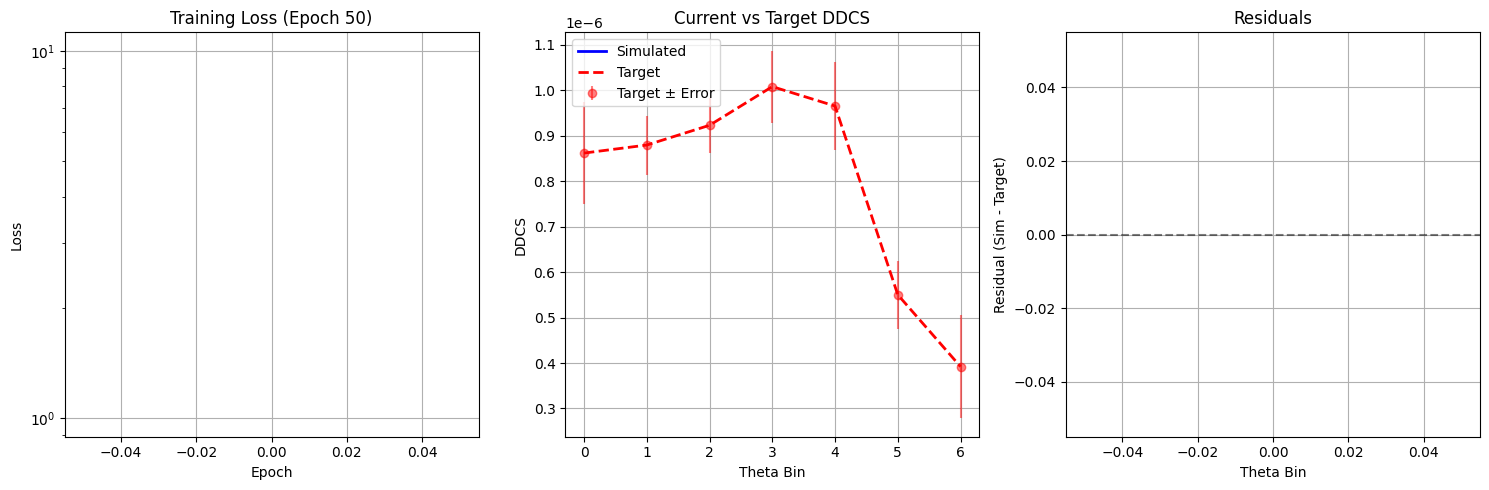


Training completed in 5.5 seconds
Final loss: nan
Best loss: nan (epoch 1)

Evaluating trained model...
NaN in KL divergence!
simulated_probs min: nan
target_probs min: 0.07024967670440674
Final evaluation:
  MSE: nan
  KL divergence: nan
  Target DDCS shape: torch.Size([7])
  Simulated DDCS shape: torch.Size([7, 100])
  Comparison shape: torch.Size([7])


In [31]:
# Configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# 1. Load and prepare experimental data
# (Assuming you have a pandas DataFrame with experimental data)
# df = pd.read_csv('your_experimental_data.csv')
experimental_data = prepare_experimental_data(df)

# # For testing purposes, let's create mock experimental data
# mock_energies = torch.tensor([14.0, 14.5, 15.0], dtype=torch.float32)  # MeV
# mock_ddcs = torch.rand((3, 8), dtype=torch.float32)  # 3 energies, 8 theta bins
# mock_errors = 0.1 * mock_ddcs  # 10% error
# mock_mask = torch.ones_like(mock_ddcs, dtype=torch.bool)
# experimental_data = (mock_energies, mock_ddcs, mock_errors, mock_mask)

# 2. Initialize trainer for a specific energy
target_energy_idx = 0  # First energy in the list
trainer = DDCSTrainer(experimental_data, target_energy_idx=target_energy_idx, device=device)

# 3. Training parameters
training_params = {
    'n_samples': 100000,      # Number of random samples per simulation
    'batch_size': 20,      # Batch size for training
    'epochs': 50,          # Total training epochs
    'lr': 1e-3,             # Learning rate
    'n_hidden': 12,          # Hidden layer size
    'n_layers': 3,           # Number of hidden layers
    'plot_every': 50,       # Plot progress every N epochs
    'loss_type': 'mse',      # 'kl' or 'mse'
}

# 4. Run training
print("\nStarting training...")
trainer.train(**training_params)

# 5. Evaluation
print("\nEvaluating trained model...")
final_ddcs, comparison_ddcs = trainer.evaluate(n_samples=100000)

# 6. Save results if needed
# torch.save(trainer.net.state_dict(), 'ddcs_model.pth')
# np.save('final_ddcs.npy', final_ddcs)
